In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [3]:
#reading words
words = open("names.txt", "r").read().splitlines()

In [4]:
#building character vocabulatry and mappings to/from integes
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)} #i.e a:1
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [6]:
#build the dataset
block_size = 3 #context length, how many characters to predict the next

def build_dataset(words):
    X, Y = [], [] #input, expected output
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix]) #prints the context and the predicted character
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [47]:
#run here, more streamlined----------------------

In [129]:
Xtr.shape, Ytr.shape #dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [82]:
n_embd = 10 #dimensionality of vector embedding of characters
n_hidden = 200 #number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd)) #2 dimensional embedding for each character
#hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3) / ((n_embd * block_size) ** 0.5)  #inputs, outputs (6*2 inputs, 100 nuerons to output to)
#b1 = torch.randn(n_hidden) *0.01
#output layer
W2 = torch.randn((n_hidden, vocab_size)) * 0.001
b2 = torch.randn(vocab_size) * 0 #tensor of zeroes

bngain = torch.ones((1, n_hidden)) #stuff for backpropogation
bnbias = torch.zeros((1, n_hidden)) #so the neurons aren't being constricted to being gausian
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True

In [75]:
sum(p.nelement() for p in parameters) #number of parameters

12297

In [76]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [77]:
lri = []
lossi = []
stepi = []

In [86]:
max_steps = 200000
batch_size = 32

for i in range (max_steps):
    #batching
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) #getting 32 random ints from X.shape[0]
    Xb, Yb = Xtr[ix], Ytr[ix] #Batch X, Y
    
    #forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) #I belive the -1 allows pytorch to infer what size you need, but I could be wrong
    hpreact = embcat @ W1 #multyplying each embedding by each weight feeding into the neuron, adding a bias, then passing it through the activation fucntion
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    #batch normalization
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #(32, 100)
    logits = h @ W2 + b2#(32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    #lr = lrs[i] #learning rate
    lr = 0.1 if i < max_steps/2 else 0.01 #learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats for optimizing learning rate
    lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    
print(loss.item())
#plt.plot(lri, lossi)

2.1536741256713867


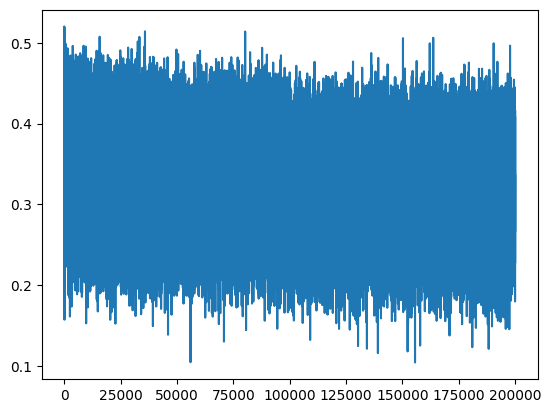

In [66]:
plt.plot(stepi, lossi)

In [71]:
#calibrate the batch norm at the end of training

with torch.no_grad():
    #passing the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [79]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    emb = C[x] #(32, 3, 2) tensor
    embcat = emb.view(emb.shape[0], -1) #I belive the -1 allows pytorch to infer what size you need, but I could be wrong
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) #(32, 100)
    logits = h @ W2 + b2#(32, 27)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss('val')

train 2.06671404838562
val 2.112468719482422


In [18]:
#sampling from the model
for _ in range(20):
    out = []
    context = [0] * block_size #initialize all with ...
    while True:
        emb = C[torch.tensor([context])] #1, block_size, d
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

roman.
rael.
len.
marrieila.
makdlie.
jarvonna.
aby.
nuj.
hailoluwaja.
haun.
mileen.
alen.
zaili.
tyrika.
scos.
joqbigu.
hanis.
hin.
gorda.
harouk.


In [87]:
#pytorch-style

In [99]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained when backpropogating)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch mean
            xvar = x.var(0, keepdim=True) #batch variance 
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #normalize to unite variance
        self.out = self.gamma * xhat + self.beta
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x): 
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

n_embd = 10 #dimensionality of the character embeddings
n_hidden = 100 #number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #make the last layer less confident?
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1
    #all other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of total parameters
for p in parameters:
    p.requires_grad = True

47551


In [100]:
#optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1) #concatenating the vectors\
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: take this out
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < max_steps/2 else 0.01 #learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    #track stats for optimizing learning rate
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break #AFTER_DEBUG: take this out too

      0/ 200000: 3.3218
